# Soft Computing

## Vežba 5 - Hough transformacija

## Detekcija ivica


Cilj detekcije ivica jeste identifikovanje značajnih obeležja na slici, odnosno važnih lokalnih oblika koji će nam pomoći da prepoznamo oblike na slici. Primeri ovakvih obeležja su: ivice, geometrijski oblici (linije, kružnice...), uglovi, domenski specifični oblici itd. 

Konvertujemo 2D sliku u skup krivih, što nam omogućava da pronađemo istaknuta obeležja scene i time dobijemo reprezentaciju slike kompaktniju od reprezentacije slike putem njenih piksela.

Pogled iz teorije informacija (eng. *information theory*): ivice kodiraju promenu, a promene su teške za  predviđanje. Zato ivice efikasno kodiraju sliku.

Postoji više operatora za detekciju ivica.


### Canny 


Canny detektor ivica (eng. *Canny edge detector*) je razvijen od strane *John F. Canny*-ja 1986. godine. Dizajniran je da bude optimalan detektor ivica:
* dobra detekcija - reaguje na ivice a ne na šum;
* dobra lokalizacija - detektovana ivica je blizu stvarne;
* minimalan odgovor - jedan po ivici.

Postupak:

1. Uklanjanje šuma
    * izglađivanje (eng. *smoothing*) Gausovim operatorom.
2. Računanje pravca i orijentacije gradijenta
    * jednostavan operator;
    * ivice na ulaznoj slici će rezultovati grebenima na izlaznoj slici.
3. Non-maximum suppression
    * obezbeđuje minimalan odgovor tako što "istanjuje" linije izlaza;
    * ivica se nalazi tamo gde je gradijent najveći;
    * algoritam ide po grebenimai (eng. *ridge tracker*) i postavlja na 0 sve piksele koji nisu na vrhu grebena.
4. Primena dva praga.

Implementacija u [OpenCV](https://docs.opencv.org/4.4.0/dd/d1a/group__imgproc__feature.html#ga04723e007ed888ddf11d9ba04e2232de) biblioteci i prateći  [tutorial](https://docs.opencv.org/4.4.0/da/d22/tutorial_py_canny.html)


<img src="images/xfiles.png">

## Hough transformacija

Hough transformacija je tehnika za izdvajanje osobina (eng. *feature extraction*) koja se koristi u analizi slike (eng. *image analysis*), računarskoj viziji (eng. *computer vision*) i digitalnoj obradi slike (eng. *digital image processing*). "Klasična" Hough transformacija se odnosila na identifikaciju linija na slici, ali je kasnije proširena na identifikovanje pozicije proizvoljnih obilika. Hough transformaciju koja je danas u najširoj upotrebi razvili su *Richard Duda* i *Peter Hart* 1972. godine oslanjajući se na patent *Paul Hough*-a iz 1962. godine. Transformacija je stekla popularnost zahvaljujući radu <a href="https://www.cs.utexas.edu/~dana/HoughT.pdf">Generalizing the Hough transform to detect arbitrary shapes</a> iz 1981. godine.

Algoritam:

1. Detekcija ivica;
2. Mapiranje piksela sa ivica na Hough prostor i snimanje u akumulator (eng. *accumulator*);
3. Interpretacija akumulatora (pronalaženje beskonačnih linija);
4. Konverzija beskonačnih linija u konačne
    * Hough transformacija ne vraća nikakve informacije o dužini linije - sve detektovane linije su beskonačne;
    * za linije konačne dužine potrebna je dodatna analiza;
    * *Probabilistic Hough Transform* - vršimo pretragu duž beskonačnih linija na binarnoj slici (sa konturama).

<img src="images/hough.png">

U OpenCV biblioteci:
* [HoughLines()](https://docs.opencv.org/4.4.0/dd/d1a/group__imgproc__feature.html#ga46b4e588934f6c8dfd509cc6e0e4545a)
* [HoughLinesP()](https://docs.opencv.org/4.4.0/dd/d1a/group__imgproc__feature.html#ga8618180a5948286384e3b7ca02f6feeb)
* [HoughLinesPointSet()](https://docs.opencv.org/4.4.0/dd/d1a/group__imgproc__feature.html#ga2858ef61b4e47d1919facac2152a160e)
* [HoughCircles()](https://docs.opencv.org/4.4.0/dd/d1a/group__imgproc__feature.html#ga47849c3be0d0406ad3ca45db65a25d2d)

## Zadatak - Sabiranje cifara

* Svaki video zapis (širine 640, a visine 480 piskela) iz **data/z1/videos/** poseduje:
    * jednu liniju koja se uvek nalazi na istoj poziciji i uvek je iste boje;
    * pokretne cifre, koje predstavljaju modifikovane cifre iz MNIST skupa podataka.
* Potrebno je izvršiti sabiranje svih cifara koje pređu preko linije. 
* Izračunati [mean absolute percentage error](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) koristeći dobijene vrednosti i tačne vrednosti iz **data/z1/res.txt**

Demo: **data/z1/demo.avi**.

Rad sa videom u [OpenCV](https://docs.opencv.org/4.4.0/d8/dfe/classcv_1_1VideoCapture.html) biblioteci.

In [15]:
import numpy as np
import cv2
from sklearn import datasets
import matplotlib.pyplot as plt
%matplotlib inline

Pošto su cifre u originalnom MNIST skupu podataka dimenzija 28x28, mi ćemo sve naše slike cifara skalirati na 28x28. **scikit-learn** nam omogućava dobavljanje MNIST skupa podataka koji ćemo iskoristiti kako bi trenirali naš klasifikator za prepoznavanje cifara. Za izdvajanje osobina sa slika iz MNIST skupa podataka koristimo HOG. 

In [16]:
def get_hog():
    # Racunanje HOG deskriptora za slike iz MNIST skupa podataka
    img_size = (28, 28)
    nbins = 9
    cell_size = (8, 8)
    block_size = (2, 2)
    hog = cv2.HOGDescriptor(_winSize=(img_size[1] // cell_size[1] * cell_size[1],
                                      img_size[0] // cell_size[0] * cell_size[0]),
                            _blockSize=(block_size[1] * cell_size[1],
                                        block_size[0] * cell_size[0]),
                            _blockStride=(cell_size[1], cell_size[0]),
                            _cellSize=(cell_size[1], cell_size[0]),
                            _nbins=nbins)
    return hog

Treniranje klasifikatora po izboru na MNIST skupu podataka.

In [17]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score


# Treniranje klasifikatora na MNIST skupu podataka
print("Učitavanje MNIST skupa podataka...")
X, y = datasets.fetch_openml("mnist_784", version=1, return_X_y=True)
features = np.array(X, 'uint8')
print(features.shape)
labels = np.array(y, 'int')

print("Priprema podataka...")
x = []
for feature in features:
    x.append(get_hog().compute(feature.reshape(28, 28)))
x = np.array(x, 'float32')

print("Treniranje klasifikatora...")
classifier = LinearSVC()
classifier.fit(x, labels)
y_train_pred = classifier.predict(x)
print("Train accuracy: ", accuracy_score(labels, y_train_pred))



Učitavanje MNIST skupa podataka...


c:\Users\neboj\OneDrive\Desktop\GIT\4. Godina 7 Semestar\Soft Computing\vezbe\venv\Lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(70000, 784)
Priprema podataka...
Treniranje klasifikatora...


c:\Users\neboj\OneDrive\Desktop\GIT\4. Godina 7 Semestar\Soft Computing\vezbe\venv\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Train accuracy:  0.9764571428571429


Detekciju konačnih linija vršimo pomoću probabilističke Hough transformacije.  
Iskoristićemo Canny za detekciju ivica.

In [18]:
def detect_line(img):
    # detekcija koordinata linije koristeci Hough transformaciju
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges_img = cv2.Canny(gray_img, 50, 150, apertureSize=3)
    plt.imshow(edges_img, "gray")
    
    # minimalna duzina linije
    min_line_length = 200
    
    # Hough transformacija
    lines = cv2.HoughLinesP(image=edges_img, rho=1, theta=np.pi/180, threshold=10, lines=np.array([]),
                            minLineLength=min_line_length, maxLineGap=20)
    
    print("Detektovane linije [[x1 y1 x2 y2]]: \n", lines)
    
    x1 = lines[0][0][0]
    y1 = 480 - lines[0][0][1]
    x2 = lines[0][0][2]
    y2 = 480 - lines[0][0][3]
    
    return (x1, y1, x2, y2)

Video procesiramo frejm (eng. *frame*) po frejm. 

Potrebno je da utvrdimo jednačinu prave $y=k\cdot x+n$ i da pronađemo krajnje tačke linije kako bi mogli da radimo proveru da li je cifra prešla preko linije. 

In [19]:
def get_line_params(line_coords):
    k = (float(line_coords[3]) - float(line_coords[1])) / (float(line_coords[2]) - float(line_coords[0]))
    n = k * (float(-line_coords[0])) + float(line_coords[1])
    return k, n

Pored toga, potrebno je pronaći regione koji predstavljaju cifre kako bi pomoću klasifikatora utvrdili o kojoj se cifri radi, kako bi je "sabrali" ako se radi o cifri koja je prešla preko linije.

Implementiramo pomoćnu metodu za detekciju prelaska broja preko linije.

In [20]:
def detect_cross(x, y, k, n):
    # detekcija da li je broj presao preko linije
    yy = k*x + n
    
    return -0.5 <= (yy - y) <= 1

Sledeći korak je implementacija metode za procesiranje videa, koja će:
* procesirati video frejm po frejm
* izdvojiti regione koji predstavljaju cifre i skalirati ih na 28 x 28;
* izdvojiti osobine koristeći HOG;
* uz pomoć klasifikatora odrediti o kojoj se cifri radi, i "sabrati" je ako je prešla preko linije.

In [22]:
def process_video(video_path, hog_descriptor, classifier):
    # procesiranje jednog videa
    sum_of_nums = 0
    k = 0
    n = 0
    
    # ucitavanje videa
    frame_num = 0
    cap = cv2.VideoCapture(video_path)
    cap.set(1, frame_num) # indeksiranje frejmova
    
    # analiza videa frejm po frejm
    while True:
        frame_num += 1
        grabbed, frame = cap.read()

        # ako frejm nije zahvacen
        if not grabbed:
            break
        
        if frame_num == 1: # ako je prvi frejm, detektuj liniju
            line_coords = detect_line(frame)
            
            k, n = get_line_params(line_coords)
            print("\nDetektovani parametri jednačine prave:")
            print("k=", k)
            print("n=", n)
            
            # izdvajanje krajnjih x koordinata linije
            line_left_x = line_coords[0]
            line_right_x = line_coords[2]
        
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        #plt.imshow(frame_gray, "gray")
        thresh, frame_bin = cv2.threshold(frame_gray, 150, 255, cv2.THRESH_BINARY)
        #plt.imshow(frame_bin, "gray")
        frame_numbers = cv2.dilate(frame_bin, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2)), iterations=1)
        #plt.imshow(frame_numbers, "gray")
        contours, _ = cv2.findContours(frame_numbers.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        rectangles = [cv2.boundingRect(contour) for contour in contours]
        
        # svaki pravougaonik je opisan sa x,y,w,h
        for rectangle in rectangles:
            x, y, w, h = rectangle
            if h > 10: 
                # isecanje cifre i skaliranje na 28x28
                roi = frame_numbers[y:y+h, x:x+w]
                roi = cv2.resize(roi, (28, 28), interpolation=cv2.INTER_NEAREST)
                cv2.imshow('Detekcija linije', roi)
                cv2.waitKey(0)
                # hog
                number_features = hog.compute(roi).reshape(1, -1)
                predicted_number = classifier.predict(number_features)[0]
                
                # centar cifre
                center_x = x + w / 2
                center_y = 480 - (y + h / 2)
                
                if (line_left_x <= center_x <= line_right_x) and (detect_cross(center_x, center_y, k, n)):
                    sum_of_nums += predicted_number

    cap.release()
    return sum_of_nums

Ostalo je još samo da obučimo klasifikator i procesiramo testni video.

In [8]:
hog = get_hog()
classifier = train_classifier(hog)

Učitavanje MNIST skupa podataka...


c:\Users\neboj\OneDrive\Desktop\GIT\4. Godina 7 Semestar\Soft Computing\vezbe\venv\Lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Priprema podataka...
Treniranje klasifikatora...


c:\Users\neboj\OneDrive\Desktop\GIT\4. Godina 7 Semestar\Soft Computing\vezbe\venv\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Train accuracy:  0.9764571428571429


Detektovane linije [[x1 y1 x2 y2]]: 
 [[[ 47 400 448  98]]

 [[ 57 399 451 102]]

 [[ 52 402 452 101]]

 [[ 48 398 255 242]]

 [[ 50 397 447  98]]]

Detektovani parametri jednačine prave:
k= 0.7531172069825436
n= 44.60349127182045


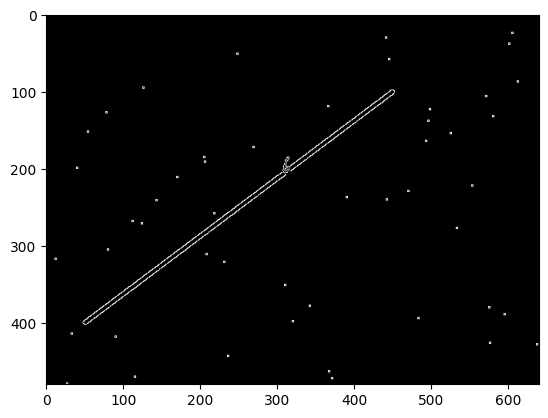

In [9]:
suma = process_video("data/z1/videos/video-0.avi", hog, classifier)

In [10]:
print("Izračunata suma: ", suma)

Izračunata suma:  70


## Zadaci

### Zadatak 1 

Pronaći sumu za svaki video zapis iz **data/z1/videos/**. Koristeći dobijene sume i tačne sume iz **data/z1/res.txt** izračunati **mean absolute percentage error.**

### Zadatak 2  

Na slikama iz **data/z2/** označiti zelenom bojom traku kojom se vozilo kreće.

### Zadatak 3 - "Teže" sabiranje cifara

Skup podataka se nalazi u **data/z3/**. Svaki video zapis iz **data/z3/videos/** poseduje:
* jednu pokretnu liniju koja je uvek iste boje;
* cifre koje predstavljaju modifikovane cifre iz MNIST skupa podataka, koje se kreću za slučajan broj koraka i prolaze iza pokretne linije.
* Potrebno je izvršiti sabiranje svih cifara koje prođu ispod linije.
* Izračunati **mean absolute percentage error** koristeći dobijene vrednosti i tačne vrednosti iz **data/z3/res.txt** datoteke.